In [9]:
import sys

print(sys.executable)

/anaconda3/bin/python


In [61]:
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits
import george
from george import kernels
import numpy as np
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as pl
import flaredetect as fd
from astropy.io import fits
from scipy.signal import savgol_filter as sf
from scipy.optimize import minimize
from numpy import asarray
import pandas as pd
import scipy.ndimage.filters as gausFilter
from astropy.stats import LombScargle
from scipy.integrate import simps

class Flare:
    flux = []
    time = []

    def __init__(self, x, y, r1, r2):

        self.flux = y[r1:r2]
        self.time = x[r1:r2]

    def getpeaktimes(self):
        return fd.flaredetecttime(self.time, self.flux)

    def guesspeaks(self):  # gathers the peaks in the set of data, then returns a list of flare times, peaks, and fwhm
        self.detflares = fd.flaredetectpeak(self.flux)
        self.flarecount = fd.getlength()
        self.nflares = np.shape(self.detflares)[0]
        self.params = np.zeros([self.nflares, 3])
        for i, flareVal in enumerate(self.detflares):
            self.flarepeak = flareVal
            self.flaretime = self.findfluxtime(self.flarepeak, self.flux, self.time)
            p = [self.flaretime, 0.004, self.flarepeak]
            self.params[i, :] = p
        return np.log(self.params)

    def findfluxtime(self, flarepeak, flux, time):  # retrieves the time of the flare
        tof = time
        for i, flare in enumerate(flux):
            if flare == flarepeak:
                return tof[i]

    def getmodel(self, p, data):  # computes the model of the flares using appaloosa's aflare1 function
        time, y, nflares = data
        p = np.exp(p)
        model = np.zeros_like([time])
        p = np.reshape(p, (nflares, 3))
        for i in range(nflares):
            model += ap.aflare1(time, tpeak=p[i, 0], fwhm=p[i, 1], ampl=p[i, 2], upsample=False, uptime=10)
        return model


<IPython.core.display.Javascript object>


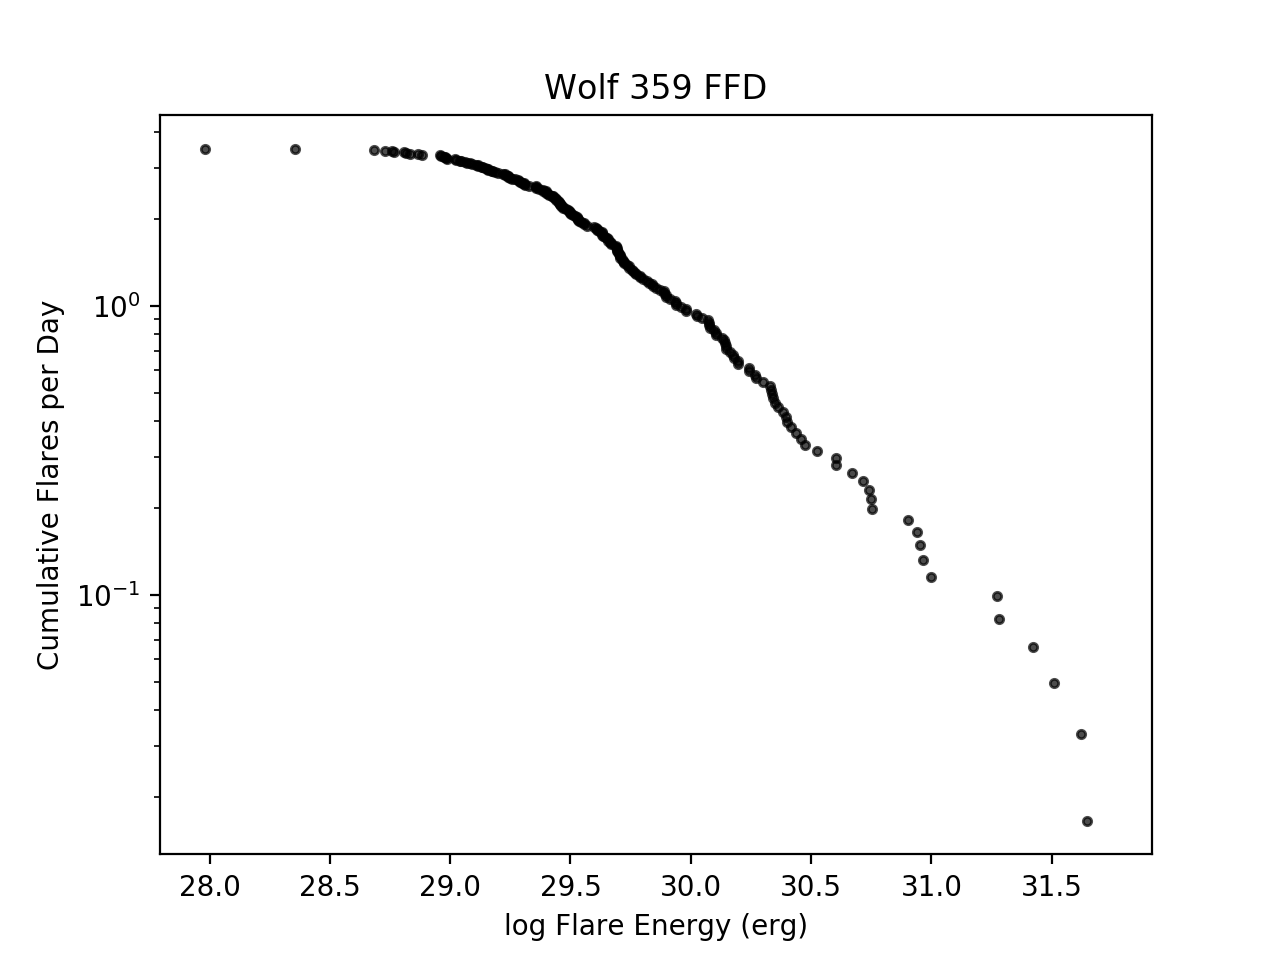

In [63]:
%matplotlib notebook
import matplotlib.pyplot as pl
import numpy as np
import os
import time
global glob_temp
tracker = 2
temp = 1
flux = 0
time = 0

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

# Simple mouse click function to store coordinates
def onclick(event):
    global timeVar
    global tracker
    global temp
    global time
    global flux
    global coords
    global prevVar
    global peaks
    global time_peaks
    
    timeVar = event.xdata
    coords.append(timeVar)
    if (len(coords) == tracker-1):
        pl.clf()
        pl.xlabel("BJD (start time)")
        pl.ylabel("Median divided flux")
        index = np.where(flare.time == time_peaks[temp])[0][0]  # get event index as an int
        start = index - 100
        end = index + 100
        pl.axvline(x=timeVar)
        prevVar = timeVar
        pl.plot(flare.time[start:end], flare.flux[start:end], color='black')
        pl.plot(flare.time[index], flare.flux[index], marker='o', color='Red')
        pl.draw()
        
    if len(coords) == tracker:
        pl.clf()
        pl.xlabel("BJD (end time)")
        pl.ylabel("Median divided flux")
        index = np.where(flare.time == time_peaks[temp])[0][0]  # get event index as an int
        start = index - 100
        end = index + 100
        pl.axvline(x=timeVar)
        pl.axvline(x=prevVar)
        pl.plot(flare.time[start:end], flare.flux[start:end], color='black')
        pl.plot(flare.time[index], flare.flux[index], marker='o', color='Red')
        pl.draw()
        if timeVar != prevVar:
            startIndex = np.where(flare.time == find_nearest(flare.time, prevVar))
            endIndex = np.where(flare.time == find_nearest(flare.time, timeVar))
            peaks.append(time_peaks[np.logical_and(time_peaks > flare.time[startIndex], time_peaks < flare.time[endIndex])])
        
    if len(coords) == (tracker+1):
        temp = temp+1
        pl.clf()
        pl.xlabel("BJD (end time)")
        pl.ylabel("Median divided flux")
        index = np.where(flare.time == time_peaks[temp])[0][0]  # get event index as an int
        start = index - 100
        end = index + 100
        pl.plot(flare.time[start:end], flare.flux[start:end], color='black')
        pl.plot(flare.time[index], flare.flux[index], marker='o', color='Red')
        pl.draw()
    
        if temp > len(time_peaks):
            fig.canvas.mpl_disconnect(cid)
            pl.clf()
            pl.close()
            
        coords.pop()
        tracker = tracker + 2
            
            
        
        

    return


def manualflare(flux, time, time_peaks):
    num_events = len(time_peaks)
    flux = np.asarray(flux)  # convert to np array
    time = np.asarray(time)
    temp_coord = 0
    index = np.where(time == time_peaks[temp])[0][0]  # get event index as an int
    start = index - 100 
    end = index + 100                
    fig = pl.figure(1)
    ax = fig.add_subplot(111)
    cur_plot = ax.plot(time[start:end], flux[start:end], color='black')  # plot the entire flare event
    ax.plot(time[index], flux[index], marker='o', color='Red')
    pl.xlabel("BJD")
    pl.ylabel("Median divided flux")
    cid = fig.canvas.mpl_connect('button_press_event', onclick) # connect the GUI interface


            
    #cid = fig.canvas.mpl_connect('button_press_event', onclick)
    
#fits_file = fits.open('/Users/Dennis/Desktop/AuMicB/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits')

file = np.genfromtxt("/Users/dennisafa/tweaked_SC_timeseries.txt", dtype=float, usecols=(0, 1), delimiter=' ')

y = file[:, 1]
x = file[:, 0]

y = y[np.logical_not(np.isnan(y))]
y = [p for p in y if p > 410000 and p < 1000000] # Lot of systematic errors below this threshold (should change for other LC's)
    # y = np.array(y)
    # y = pd.rolling_median(y, 30)
x = x[:len(y)]

flare = Flare(x, y, 0, len(y))
flare.flux = np.array(flare.flux)

smo1 = pd.Series(flare.flux).rolling(100, center=True).median()
smo2 = pd.Series(flare.flux-smo1).rolling(2, center=True).median()
smo1 = np.asarray(smo1)
smo2 = np.asarray(smo2)
y = np.isfinite(smo2)

flare.flux = ((flare.flux[y] - smo1[y]) / np.median(flare.flux))
flare.time = flare.time[:len(flare.flux)]
time_peaks = flare.getpeaktimes()

coords = []
finalTimes = []
peaks = []
tempVal = 0
trackClick = 0
time_peaks = np.asarray(time_peaks)
manualflare(flare.flux, flare.time, time_peaks)




In [65]:
finalTimes = []
indexedTimes = []
a_flare = []

for i in range(0, len(coords)-2, 2):
    if coords[i] != coords[i+1]:
        finalTimes.append((coords[i], coords[i+1])) # check for double clicks
                
for i in range(0, len(finalTimes), 1):
    startTime = np.where(flare.time == (find_nearest(flare.time, finalTimes[i][0])))[0][0]
    endTime = np.where(flare.time == (find_nearest(flare.time, finalTimes[i][1])))[0][0]
    indexedTimes.append((startTime, endTime))
    a_flare.append(np.trapz(flare.flux[startTime:endTime], flare.time[startTime:endTime] * 86400))
        
print(len(finalTimes))
print(peaks)
# Calculate integral
#y_int = np.log10(trapz(flare.flux[ch1[0][0]:ch2[0][0]],flare.time[ch1[0][0]:ch2[0][0]] * 86400))
#print(y_int)

217
[array([57905.97490948, 57905.9783149 ]), array([57906.07298559, 57906.07775314, 57906.07979643, 57906.0859262 ]), array([57906.12474795]), array([57906.19081304, 57906.1935375 ]), array([57906.20375375]), array([57906.23099711]), array([57906.27867287, 57906.28139732]), array([57906.31885683]), array([57906.47210075]), array([57906.52250095, 57906.52863072]), array([57906.56404693]), array([57906.62057689]), array([57906.661442  , 57906.66484732, 57906.6689339 , 57906.67778792]), array([57906.67778792]), array([57906.68664214]), array([57906.6893664 , 57906.69072862]), array([57906.7377233 , 57906.74998283]), array([], dtype=float64), array([57906.8378426 , 57906.84942107, 57906.8507831 ]), array([57906.89641573]), array([57907.1552274 , 57907.15727069]), array([57907.19404909]), array([57907.25194114]), array([57907.37862262]), array([57907.39020098]), array([], dtype=float64), array([57907.44264441]), array([57907.62721778, 57907.62857991]), array([57907.77978028]), array([57907

In [67]:
exptime = 1. / 24. / 80.
# print(flare.time[len(flare.time)-1] - flare.time[-1])

totdur = float(len(flare.time)) * exptime
duration = np.sort(a_flare)[::-1]

ddx = np.log10(duration)
ddy = (np.arange(len(ddx))) / totdur
pl.plot(ddx, ddy, 'o--', markersize=2, alpha=0.5)
pl.yscale('log')
pl.xlabel('log Equivalent Duration (seconds)')
pl.ylabel('Cumulative Flares per Day')
pl.clf()

E_point = 29.20848418222753

print("Rough energy calc", E_point)

pl.plot(ddx + E_point, ddy, 'o', color='Black', markersize=3, alpha=0.7)
pl.title("Wolf 359 FFD")
pl.yscale('log')
#pl.ylim(1e-20, 1e3)
pl.xlabel('log Flare Energy (erg)')
pl.ylabel('Cumulative Flares per Day')
print(ddy[-1], ddx[-1]+E_point)
print(ddx+E_point)
pl.show()


Rough energy calc 29.20848418222753
3.569356823795712 nan
[31.72944465 31.64492612 31.622322   31.51122798 31.42100352 31.28241929
 31.27432938 30.99837197 30.96453267 30.95423404 30.93904105 30.90312122
 30.75521781 30.75045727 30.73942327 30.7171144  30.67155898 30.60503211
 30.60493821 30.52637528 30.47338278 30.45690985 30.43632716 30.41851778
 30.40032159 30.39436161 30.38350041 30.36154273 30.34897745 30.34237206
 30.33739077 30.33368572 30.33013458 30.301909   30.26999327 30.26881803
 30.2415485  30.2412676  30.19747778 30.19501196 30.18099661 30.17394325
 30.16383666 30.1471446  30.14446393 30.14118179 30.13855156 30.13177829
 30.10527327 30.10368024 30.09540921 30.07914214 30.07743376 30.07403563
 30.07030594 30.04716664 30.02520077 30.02361194 29.98083814 29.98050019
 29.96094175 29.9394534  29.93837757 29.93542304 29.91369384 29.89838433
 29.89697007 29.88978363 29.8885962  29.8719405  29.8575151  29.84266559
 29.83775593 29.82776378 29.81832342 29.80266112 29.78783108 29.78

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


In [66]:
with open('wolf359FlareTimes.txt', 'w') as f:
    for item in finalTimes:
        f.write("%f %f\n" % item)

In [64]:
print(flare.time[-1])

57984.97276138066
